In [1]:
import networkx as nx
import torch
import torch_geometric
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define noising schedule and posterior probability

In [3]:
HALF = torch.tensor(0.5, device=DEVICE)
def beta_func(t, epsilon=1e-6):
    """
    Maps a tensor of times `t` to particular noise levels beta.
    Arguments:
        `t`: a tensor of times
        `epsilon`: a small number for numerical stability
    Returns an equivalently shaped tensor of beta values.
    """
    return torch.minimum(torch.sigmoid((t / 100) - 10), HALF - epsilon)

LOG2 = torch.log(torch.tensor(2, device=DEVICE))
def beta_bar_func(t):
    """
    Maps a tensor of times `t` to beta-bar values. If each beta is a probability
    of a flip at some particular time, then beta-bar is the probability of a
    flip from 0 until this `t`.
    Arguments:
        `t`: a B-tensor of times
    Returns a B-tensor of beta-bar values.
    """
    max_range = torch.arange(1, torch.max(t) + 1, device=DEVICE)
    betas = beta_func(max_range)  # Shape: maxT

    betas_tiled = torch.tile(betas, (t.shape[0], 1))  # Shape: B x maxT
    biases = 0.5 - betas_tiled

    # Anything that ran over a time t, set to 1
    mask = max_range[None] > t[:, None]
    biases[mask] = 1
    
    # Do the product in log-space and transform back for stability
    coef = (t - 1) * LOG2
    log_prod = torch.sum(torch.log(biases), dim=1)
    prod = torch.exp(coef + log_prod)

    return 0.5 - prod

In [4]:
def _inflate_dims(v, num_dims):
    """
    Given a tensor vector `v`, appends dimensions of size 1 so that
    it has `num_dims` dimensions. Forexample, if `num_dims` is 3,
    this turns `v` from a B-tensor to a B x 1 x 1 tensor.
    Arguments:
        `v`: a B-tensor
        `num_dims`: an integer greater than 1
    Returns a B x ... tensor of dimension `num_dims`.
    """
    return v[(slice(None),) + ((None,) * (num_dims - 1))]

In [5]:
def noise_input(x0, t):
    """
    Given a binary input at time 0, return a version of the input that
    has noise added to it at time `t` based on random bit flips.
    Arguments:
        `x0`: a binary B x ... tensor of bits at time 0
        `t`: time to add noise to, a B-tensor
    Returns a new binary B x ... tensor, and leaves the originals untouched.
    """
    prob_flip = torch.tile(
        _inflate_dims(beta_bar_func(t), len(x0.shape)), (1, *x0.shape[1:])
    )
    
    flip_indicators = torch.bernoulli(prob_flip)

    # Perform flips
    xt = x0.clone()
    mask = flip_indicators == 1
    xt[mask] = 1 - x0[mask]

    return xt

In [6]:
def posterior_prob(x0, xt, t):
    """
    Compute the probability of an bit at time t - 1, given the bits at time 0
    and t.
    Arguments:
        `x0`: a binary B x ... tensor at time 0
        `xt`: a binary B x ... tensor at time t
        `t`: B-tensor of times
    Returns a B x ... tensor of probabilities that a bit would be 1 at time
    t - 1.
    """
    beta_t = _inflate_dims(beta_func(t), len(x0.shape))
    beta_bar_t = _inflate_dims(beta_bar_func(t), len(x0.shape))
    beta_bar_t_1 = _inflate_dims(beta_bar_func(t - 1), len(x0.shape))

    term_1 = ((1 - xt) * beta_t) + (xt * (1 - beta_t))
    term_2 = ((1 - x0) * beta_bar_t_1) + (x0 * (1 - beta_bar_t_1))
    x0_xor_xt = torch.square(x0 - xt)
    term_3 = (x0_xor_xt * beta_bar_t) + ((1 - x0_xor_xt) * (1 - beta_bar_t))

    probs = term_1 * term_2 / term_3
    
    # Due to small numerical instabilities (particularly at t = 0), clip the
    # probabilities here
    return torch.clamp(probs, 0, 1)

### Utility functions for converting graph formats

In [7]:
def get_nx_edges(graph):
    """
    Returns a binary E-array of the edges in a NetworkX graph in
    canonical order. Note that self-edges are not allowed.
    Arguments:
        `graph`: a NetworkX graph
    """
    num_nodes = graph.number_of_nodes()
    return nx.to_numpy_array(graph)[np.triu_indices(num_nodes, k=1)]

def set_nx_edges(graph, edges):
    """
    Sets the edges in the adjacency matrix of a NetworkX graph
    according to the given edges. Note that self-edges are not allowed.
    Arguments:
        `graph`: a NetworkX graph
        `edges`: a binary E-array of edges in canonical order
    """
    num_nodes = graph.number_of_nodes()
    assert len(edges) == (num_nodes * (num_nodes - 1)) // 2

    edges_to_set = np.stack(np.triu_indices(num_nodes, k=1), axis=1)[edges == 1]

    graph.clear_edges()

    for u, v in edges_to_set:
        graph.add_edge(u, v)

def get_nx_node_features(graph):
    """
    Returns a V x D array of the node features of a NetworkX graph
    in canonical order.  
    Arguments:
        `graph`: a NetworkX graph
    """
    feat_dict = nx.get_node_attributes(graph, "feats")
    return np.vstack([feat_dict[i] for i in range(graph.number_of_nodes())])

def set_nx_node_features(graph, feats):
    """
    Sets the node features in the NetworkX graph to the given array.
    Arguments:
        `graph`: a NetworkX graph
        `feats`: a V x D array of node features in canonical order
    """
    feat_dict = {i : feats[i] for i in range(graph.number_of_nodes())}
    nx.set_node_attributes(graph, feat_dict, "feats")

In [8]:
def pyg_data_to_edge_vector(data, return_batch_inds=False):
    """
    Returns a binary E-tensor of the edges from a torch-geometric Data
    object in canonical order. Note that self-edges are not allowed.
    Arguments:
        `data`: a torch-geometric Data object
        `return_batch_inds`: if True, also return an E-tensor which
            contains the index of the individual graph each edge
            belongs to
    Returns a binary E-tensor of edges, and optionally another E-tensor
    of batch inds (type int)
    """
    # First, get (padded) adjacency matrix of size B x V x V, where V is
    # the maximum number of nodes in any individual graph
    adj_matrix = torch_geometric.utils.to_dense_adj(data.edge_index, data.batch)
    
    # Create boolean mask of only the top upper triangle of each B x V x V
    # matrix, ignoring the diagonal
    graph_sizes = torch.diff(data.ptr)
    triu_mask = torch.triu(torch.ones_like(adj_matrix), diagonal=1) == 1
    for i, size in enumerate(torch.diff(data.ptr)):
        # TODO: make this more efficient
        # For each individual graph, limit the upper-triangle mask to
        # only the size of that graph
        triu_mask[i, :, size:] = False
        
    # Edge vector is all entries in the graph-specific upper triangle of each
    # individual adjacency matrix
    edge_vec = adj_matrix[triu_mask]
    
    if return_batch_inds:
        # Number of edges in each graph:
        edge_counts = ((graph_sizes * (graph_sizes - 1)) / 2).int()
        edge_counts_cumsum = torch.cumsum(edge_counts, dim=0)
        
        # Create binary marker array, which is all 0s except with 1s
        # wherever we switch to a new graph
        markers = torch.zeros(edge_counts_cumsum[-1], dtype=torch.int, device=DEVICE)
        markers[edge_counts_cumsum[:-1]] = 1
        
        batch_inds = torch.cumsum(markers, dim=0)
        return edge_vec, batch_inds
    return edge_vec

def edge_vector_to_pyg_data(data, edges, reflect=True):
    """
    Returns the edge-index tensor which would be associated with the
    torch-geometric Data object `data`, if the edges in the edge index
    attribute were set according to the given edges. Note that self-edges
    are not allowed. If `edges` is a scalar 1, then this returns the set
    of all edges as an edge-index tensor
    Arguments:
        `data`: a torch-geometric Data object
        `edges`: a binary E-tensor of edges in canonical order, or the
            scalar 1
        `reflect`: by default, each edge will be represented twice in the
            edge-index tensor (no self-edges are allowed); if False, only
            the upper-triangular indices will be present (and thus the
            tensor's size will be halved)
    Returns a 2 x E' edge-index tensor (type long).
    """
    graph_sizes = torch.diff(data.ptr)
    max_size = torch.max(graph_sizes)
    
    # Create filler adjacency matrix that starts out as all 0s
    adj_matrix = torch.zeros(graph_sizes.shape[0], max_size, max_size, device=DEVICE)
    
    # Create boolean mask of only the top upper triangle of each B x V x V
    # matrix, ignoring the diagonal
    triu_mask = torch.triu(torch.ones_like(adj_matrix), diagonal=1) == 1
    for i, size in enumerate(torch.diff(data.ptr)):
        # TODO: make this more efficient
        # For each individual graph, limit the upper-triangle mask to
        # only the size of that graph
        triu_mask[i, :, size:] = False
        
    # Set the upper triangle of each graph-specific adjacency matrix to
    # the edges given,
    adj_matrix[triu_mask] = edges
    
    # Symmetrize the matrix
    if reflect:
        adj_matrix = adj_matrix + torch.transpose(adj_matrix, 1, 2)
    
    # Get indices where the adjacency matrix is nonzero (an E x 3 matrix)
    nonzero_inds = adj_matrix.nonzero()
    
    # The indices are for each individual graph, so add the graph-size
    # pointers to each set of indices so later graphs have higher
    # indices based on the sizes of earlier graphs
    edges_to_set = nonzero_inds[:, 1:] + data.ptr[nonzero_inds[:, 0]][:, None]
    
    # Convert to a 2 x E matrix
    edges_to_set = edges_to_set.t().contiguous()
    return torch_geometric.utils.sort_edge_index(edges_to_set).long()

In [9]:
def split_pyg_data_to_nx_graphs(data):
    """
    Given a torch-geometric Data object, splits the objects into an
    ordered list of NetworkX graphs. The NetworkX graphs will be
    undirected (no self-edges allowed), and node features will be
    under the attribute "feats".
    Arguments:
        `data`: a batched torch-geometric Data object
    Returns an ordered list of NetworkX graph objects.
    """
    graphs = []
    pointers = data.ptr.cpu().numpy()
    graph_sizes = np.diff(pointers)
    num_graphs = len(graph_sizes)

    # First, get (padded) adjacency matrix of size B x V x V, where V is
    # the maximum number of nodes in any individual graph
    adj_matrix = torch_geometric.utils.to_dense_adj(data.edge_index, data.batch)

    for i in range(num_graphs):
        graph = nx.empty_graph(graph_sizes[i])
        
        # Get the indices of adjacency matrix, upper triangle only
        edge_indices = torch.triu(adj_matrix[i], diagonal=1).nonzero().cpu().numpy()
        for u, v in edge_indices:
            graph.add_edge(u, v)

        node_feats = data.x[pointers[i] : pointers[i + 1]].cpu().numpy()
        feat_dict = {i : node_feats[i] for i in range(graph.number_of_nodes())}
        nx.set_node_attributes(graph, feat_dict, "feats")

        graphs.append(graph)
    return graphs

### Data loading

In [10]:
def create_random_tree(num_nodes, node_dim, noise_level=1):
    """
    Creates a random connected tree. The node attributes will be initialized
    by a random vector plus the distance from a randomly selected source node,
    plus noise.
    Arguments:
        `num_nodes`: number of nodes in the graph
        `node_dim`: size of node feature vector
        `noise_level`: standard deviation of Gaussian noise to add to
            distances
    Returns a NetworkX Graph with NumPy arrays as node attributes.
    """
    g = nx.random_tree(num_nodes)

    node_features = np.empty((num_nodes, node_dim))
    
    # Pick a random source node
    source = np.random.choice(num_nodes)
    
    # Set source node's feature to random vector
    source_feat = np.random.randn(node_dim) * 2 * np.sqrt(num_nodes)
    node_features[source] = source_feat
    
    # Run BFS starting from source node; for each layer, set features
    # to be the source vector plus the distance plus noise
    current_layer = [source]
    distance = 1
    visited = set(current_layer)
    while current_layer:
        next_layer = []
        for node in current_layer:
            for child in g[node]:
                if child not in visited:
                    visited.add(child)
                    next_layer.append(child)
                    node_features[child] = source_feat + distance + (np.random.randn(node_dim) * noise_level)
        current_layer = next_layer
        distance += 1

    nx.set_node_attributes(g, {i : node_features[i] for i in range(num_nodes)}, "feats")
    return g

In [11]:
def create_random_uniform_cliques(num_nodes, node_dim, clique_size=6, noise_level=1):
    """
    Creates a random graph of disconnected cliques. The node attributes
    will be initialized by a constant vector for each clique, plus some
    noise. If `clique_size` does not divide `num_nodes`, there will be
    a smaller clique.
    Arguments:
        `num_nodes`: number of nodes in the graph
        `node_dim`: size of node feature vector
        `clique_size`: size of cliques
        `noise_level`: standard deviation of Gaussian noise to add to
            node features
    Returns a NetworkX Graph with NumPy arrays as node attributes.
    """
    g = nx.empty_graph()
    
    clique_count = 0
    while g.number_of_nodes() < num_nodes:
        size = min(clique_size, num_nodes - g.number_of_nodes())
        
        # Create clique
        clique = nx.complete_graph(size)
        
        # Create the core feature vector for the clique
        core = np.ones((node_dim, 1)) * clique_count * (2 * num_nodes / clique_size)
        
        # Add a small bit of noise to for each node in the clique
        node_features = core + (np.random.randn(size, node_dim) * noise_level)
        nx.set_node_attributes(clique, {i : node_features[i] for i in range(size)}, "feats")
        
        # Add the clique to the graph
        g = nx.disjoint_union(g, clique)
        clique_count += 1
        
    return g

In [12]:
def create_random_diverse_cliques(
    num_nodes, node_dim, clique_sizes=[3, 4, 5], repeat=False, noise_level=1
):
    """
    Creates a random graph of disconnected cliques. The node attributes
    will be initialized by a constant vector for each clique (which is
    the size of the clique), plus some noise. Leftover nodes will be
    singleton nodes.
    Arguments:
        `num_nodes`: number of nodes in the graph
        `node_dim`: size of node feature vector
        `clique_sizes`: iterable of clique sizes to use
        `repeat`: if False, all clique sizes will be unique
        `noise_level`: standard deviation of Gaussian noise to add to
            node features
    Returns a NetworkX Graph with NumPy arrays as node attributes.
    """
    g = nx.empty_graph()
    
    clique_sizes = np.unique(clique_sizes)
    
    sizes_to_make, size_left = [], num_nodes
    if repeat:
        while clique_sizes.size:
            size = np.random.choice(clique_sizes)
            sizes_to_make.append(size)
            size_left -= size
            clique_sizes = clique_sizes[clique_sizes >= size_left]
    else:
        clique_sizes = np.random.permutation(clique_sizes)
        for size in clique_sizes:
            if size <= size_left:
                sizes_to_make.append(size)
                size_left -= size
    sizes_to_make.extend([1] * size_left)
    
    for size in sizes_to_make:
        # Create clique
        clique = nx.complete_graph(size)
        
        # Create the core feature vector for the clique
        core = np.ones((size, 1)) * size
        
        # Add a small bit of noise to for each node in the clique
        node_features = core + (np.random.randn(size, node_dim) * noise_level)
        nx.set_node_attributes(clique, {i : node_features[i] for i in range(size)}, "feats")
        
        # Add the clique to the graph
        g = nx.disjoint_union(g, clique)
        
    return g

In [13]:
class RandomGraphDataset(torch.utils.data.Dataset):
    def __init__(
        self, num_nodes, node_dim, graph_type="tree", num_items=1000,
        **kwargs
    ):
        """
        Create a PyTorch IterableDataset which yields random graphs.
        Arguments:
            `num_nodes`: number of nodes in the graph; can be an
                integer or a NumPy array of integers to sample from
                uniformly
            `node_dim`: size of node feature vector
            `num_items`: number of items to yield in an epoch
            `graph_type`: type of graph to generate; can be "tree",
                "uniform_cliques", or "diverse_cliques"
            `kwargs`: extra keyword arguments for the graph generator
        """
        super().__init__()
        
        if type(num_nodes) is int:
            num_nodes = np.array([num_nodes])
            
        self.num_nodes = num_nodes
        self.node_dim = node_dim
        self.num_items = num_items
        self.graph_type = graph_type
        self.kwargs = kwargs

    def __getitem__(self, index):
        """
        Returns a single data point generated randomly, as a
        torch-geometric Data object. `index` is ignored.
        """
        num_nodes = np.random.choice(self.num_nodes)
        if self.graph_type == "tree":
            graph = create_random_tree(num_nodes, self.node_dim, **self.kwargs)
        elif self.graph_type == "uniform_cliques":
            graph = create_random_uniform_cliques(num_nodes, self.node_dim, **self.kwargs)
        elif self.graph_type == "diverse_cliques":
            graph = create_random_diverse_cliques(num_nodes, self.node_dim, **self.kwargs)
        data = torch_geometric.utils.from_networkx(
            graph, group_node_attrs=["feats"]
        )
        data.edge_index = torch_geometric.utils.sort_edge_index(data.edge_index)
        return data.to(DEVICE)

    def __len__(self):
        return self.num_items

### Neural network architecture and training

In [14]:
class GraphLinkPredictor(torch.nn.Module):

    def __init__(
        self, input_dim, t_limit, num_gnn_layers=4, hidden_dim=10, time_embed_size=256
    ):
        """
        Initialize a time-dependent GNN which predicts bit probabilities for
        each edge.
        Arguments:
            `input_dim`: the dimension of the input node features
            `t_limit`: maximum time horizon
            `num_gnn_layers`: number of GNN layers to have
            `hidden_dim`: the dimension of the hidden node embeddings
            `time_embed_size`: size of the time embeddings
        """
        super().__init__()
        
        self.t_limit = t_limit
        self.num_gnn_layers = num_gnn_layers
        
        self.time_embed_dense = torch.nn.Linear(3, time_embed_size)
        
        self.swish = lambda x: x * torch.sigmoid(x)
        self.relu = torch.nn.ReLU()
        
        # GNN layers
        num_heads = 4  # Number of attention heads
        self.gnn_layers = torch.nn.ModuleList()
        self.gnn_batch_norms = torch.nn.ModuleList()
        for i in range(num_gnn_layers):
            gnn_layer = torch_geometric.nn.GATv2Conv(
                input_dim + time_embed_size if i == 0 else hidden_dim * num_heads,
                hidden_dim, heads=num_heads
            )
            gnn_batch_norm = torch_geometric.nn.LayerNorm(hidden_dim * num_heads)

            self.gnn_layers.append(gnn_layer)
            self.gnn_batch_norms.append(gnn_batch_norm)
            
        # Link prediction
        self.link_dense = torch.nn.Linear(hidden_dim * num_heads, 1)
        
        # Loss
        self.bce_loss = torch.nn.BCELoss()
        
    def forward(self, data, t):
        """
        Forward pass of the network.
        Arguments:
            `data`: a (batched) torch-geometric Data object
            `t`: a V-tensor containing the time to train on for each
                node; note that the time should be the same for nodes
                belonging to the same individual graph
        Returns an E-tensor of probabilities of each edge at time t - 1,
        where E is the total possible number of edges, and is in canonical
        ordering.
        """
        # Get the time embeddings for `t`
        time_embed_args = t[:, None] / self.t_limit  # Shape: V x 1
        time_embed = self.swish(self.time_embed_dense(
                torch.cat([
                    torch.sin(time_embed_args * (np.pi / 2)),
                    torch.cos(time_embed_args * (np.pi / 2)),
                    time_embed_args
                ], dim=1)
        ))  # Shape: V x Dt
        
        # Concatenate initial node features and time embedding
        node_embed = torch.cat([data.x.float(), time_embed], dim=1)  # Shape: V x D
        
        # GNN layers
        for i in range(self.num_gnn_layers):
            node_embed = self.gnn_batch_norms[i](
                self.gnn_layers[i](node_embed, data.edge_index),
                data.batch
            )
            
        # For all possible edges (i.e. node pairs), compute probability
        edge_inds = edge_vector_to_pyg_data(data, 1, reflect=False)  # Shape: 2 x E
        node_embed_1 = node_embed[edge_inds[0]]  # Shape: E x D'
        node_embed_2 = node_embed[edge_inds[1]]  # Shape: E x D'
        node_prod = node_embed_1 * node_embed_2
        
        edge_probs = torch.sigmoid(self.link_dense(node_prod))[:, 0]
        
        return edge_probs

    def loss(self, pred_probs, true_probs):
        """
        Computes the loss of a batch.
        Arguments:
            `pred_probs`: an E-tensor of predicted probabilities
            `true_probs`: an E-tensor of true probabilities
        Returns a scalar loss value.
        """
        return self.bce_loss(pred_probs, true_probs)

In [15]:
def train_model(model, data_loader, t_limit, num_epochs, learning_rate):
    """
    Trains a ProbGraphEdge model.
    Arguments:
        `model`: an initialized GraphLinkPredictor model
        `data_loader`: a DataLoader which iterates over batches of
            random graphs as `torch_geometric` Data objects
        `t_limit`: maximum time range for noising
        `num_epochs`: number of epochs to train for
        `learning_rate`: learning rate to use for training
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    torch.set_grad_enabled(True)

    for epoch_num in range(num_epochs):
        losses = []
        t_iter = tqdm.notebook.tqdm(
            data_loader, total=len(data_loader), desc="Loss: -----"
        )

        for data in t_iter:
            e0, edge_batch_inds = pyg_data_to_edge_vector(data, return_batch_inds=True)  # Shape: E
            
            # Pick some random times t between 1 and t_limit (inclusive),
            # one value for each individual graph
            graph_sizes = torch.diff(data.ptr)
            graph_times = torch.randint(t_limit, size=(graph_sizes.shape[0],), device=DEVICE) + 1
            
            # Tile the graph times to the size of all nodes
            t_v = graph_times[data.batch].float()  # Shape: V
            t_e = graph_times[edge_batch_inds].float()  # Shape: E

            # Add noise to edges from time 0 to time t
            et = noise_input(e0[:, None], t_e)[:, 0]  # Do the noising on E x 1 tensors
            data.edge_index = edge_vector_to_pyg_data(data, et)  # Note: this modifies `data`

            # Compute posterior probability of bits
            true_probs = posterior_prob(e0, et, t_e)

            # Have model try and predict posterior probability
            pred_probs = model(data, t_v)

            loss = model.loss(pred_probs, true_probs)
            
            if not np.isfinite(loss.item()):
                continue
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t_iter.set_description(
                "Loss: %6.5f" % loss.item()
            )
            losses.append(loss.item())

        print("Epoch %d average loss: %.5f" % (epoch_num + 1, np.mean(losses)))
        torch.save(model.state_dict(), "ckpt.pth")

### Create the data loader and model

In [16]:
# Create the data loader for training
num_nodes, node_dim = 10, 5
t_limit = 1000

dataset = RandomGraphDataset(
    num_nodes, node_dim, num_items=6400,
    graph_type="diverse_cliques", clique_sizes=[3, 4, 5, 6], noise_level=0
)
data_loader = torch_geometric.loader.DataLoader(
    dataset, batch_size=32, shuffle=False, num_workers=0  # TODO: allow multi-processing
)

In [17]:
# Create the model
model = GraphLinkPredictor(node_dim, t_limit, num_gnn_layers=4).to(DEVICE)

### Sanity checks and unit tests

In [18]:
# Check the canonical ordering of edges from torch-geometric Data
data = next(iter(data_loader))

# Get the set of edges in this batch of graphs that actually exist
edge_indices = set(["%d-%d" % (a, b) for a, b in data.edge_index.t().cpu().numpy()])

# Get the binary vector of edge indicators in canonical ordering
edges = pyg_data_to_edge_vector(data).cpu().numpy()

# Get the list of all possible edges in the same canonical ordering
all_edge_indices = edge_vector_to_pyg_data(data, 1, reflect=False).t().cpu().numpy()

assert np.sum(edges) == len(edge_indices) / 2
for i, (a, b) in enumerate(all_edge_indices):
    # For each possible edge, check its corresponding entry in `edges` and verify
    # its presence (or absence) in the set of edges that actually exist
    e1, e2 = "%d-%d" % (a, b), "%d-%d" % (b, a)
    if edges[i] == 0:
        assert e1 not in edge_indices and e2 not in edge_indices
    else:
        assert e1 in edge_indices and e2 in edge_indices

/gstore/home/tsenga5/miniconda3/envs/graph-diff/lib/python3.8/site-packages/torch_geometric/utils/convert.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  data[key] = torch.tensor(value)


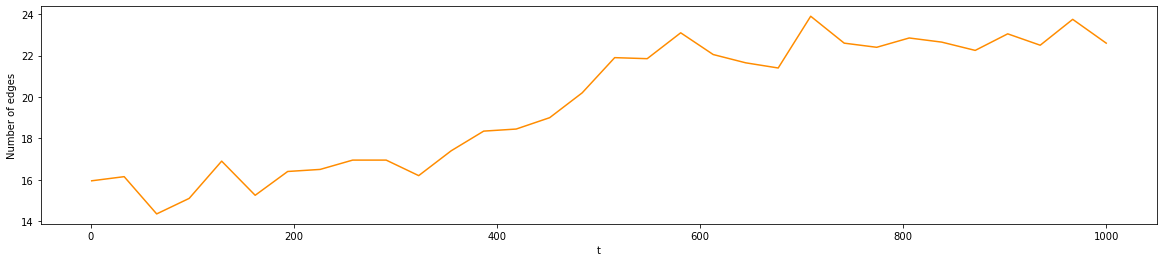

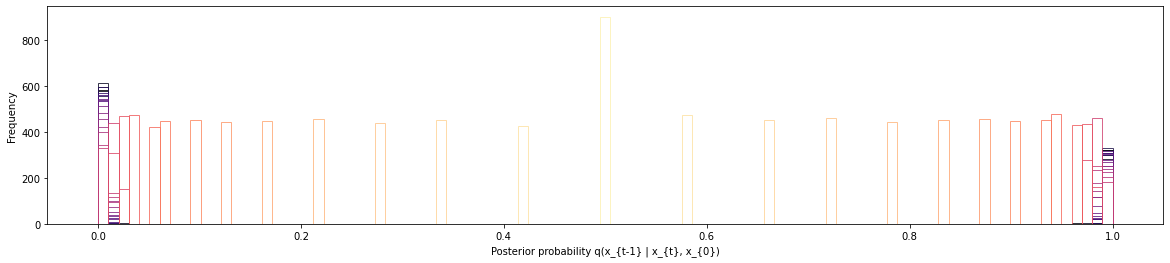

In [19]:
# Check that we can specify different times in a batch to noise edges, and
# the posterior probabilities are also as expected
num_batches_to_test = 20

# Take a set of uniformly distributed times from 0 to t_limit, one for each
# graph in a batch
graph_times = np.linspace(1, t_limit, data_loader.batch_size).astype(int)

noised_graphs = {t : [] for t in graph_times}
post_probs = {t : [] for t in graph_times}
for _ in range(num_batches_to_test):
    data = next(iter(data_loader))
    e0, edge_batch_inds = pyg_data_to_edge_vector(data, return_batch_inds=True)

    # Create time vector over the graphs in a single batch, but in random
    # order
    graph_times_batch = np.random.permutation(graph_times)
    t_e = torch.tensor(graph_times_batch, device=DEVICE)[edge_batch_inds]

    # Noise graphs and compute posterior probabilities
    et = noise_input(e0[:, None], t_e)[:, 0]  # Do the noising on E x 1 tensors
    data.edge_index = edge_vector_to_pyg_data(data, et)
    graphs = split_pyg_data_to_nx_graphs(data)
    p = posterior_prob(e0, et, t_e)
    
    # Save the graphs and posterior probabilities by time
    for i in range(data_loader.batch_size):
        noised_graphs[graph_times_batch[i]].append(graphs[i])
        post_probs[graph_times_batch[i]].append(p[edge_batch_inds == i].cpu().numpy())

# Check the noising process in terms of number of edges (in sorted order of time)
edge_counts = [np.mean([g.number_of_edges() for g in noised_graphs[t]]) for t in graph_times]
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(graph_times, edge_counts, color="darkorange")
ax.set_xlabel("t")
ax.set_ylabel("Number of edges")
plt.show()

# Check the posterior probabilities over time (in sorted order of time)
fig, ax = plt.subplots(figsize=(20, 4))
cmap = plt.get_cmap("magma")
bins = np.linspace(0, 1, 100)
for t_i, t in enumerate(graph_times):
    p = np.concatenate(post_probs[t])
    ax.hist(p, bins=bins, histtype="step", color=cmap(t_i / len(graph_times)), alpha=0.8)
ax.set_xlabel("Posterior probability q(x_{t-1} | x_{t}, x_{0})")
ax.set_ylabel("Frequency")
plt.show()

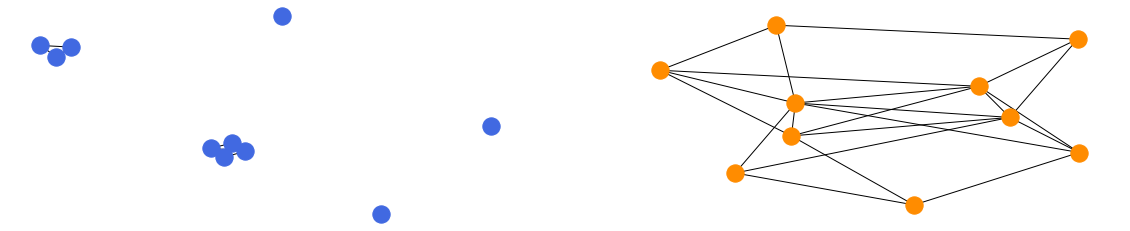

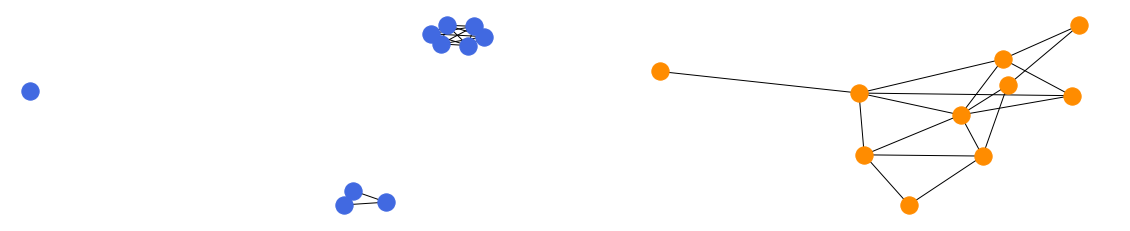

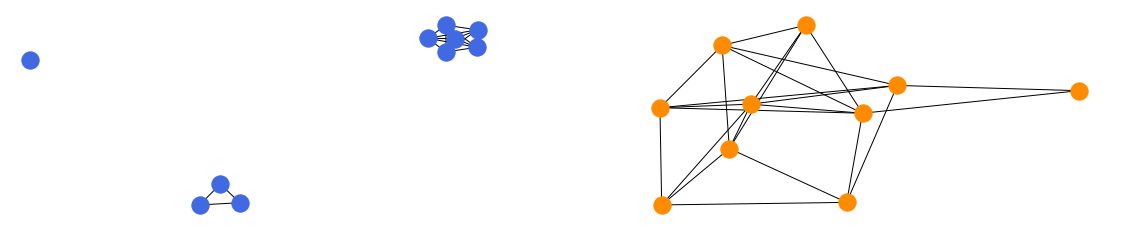

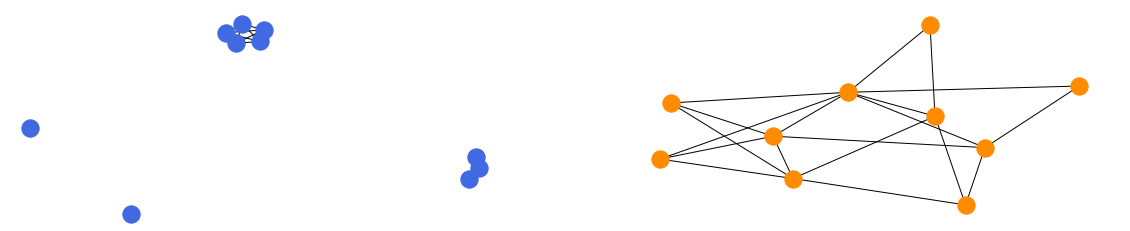

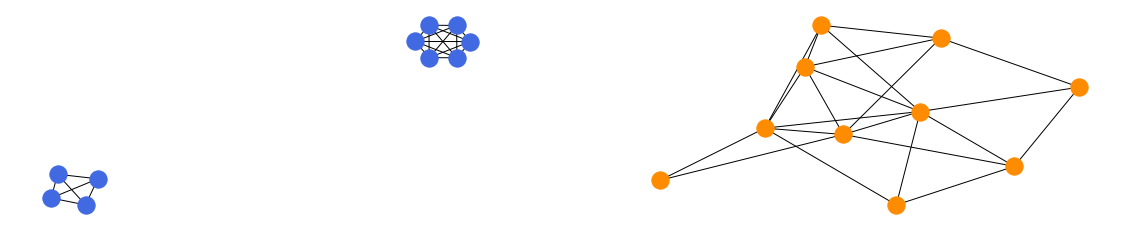

In [20]:
# Check the NetworkX graphs in a batch directly from the data loader, and
# after adding noise for a long time
data = next(iter(data_loader))

graphs_0 = split_pyg_data_to_nx_graphs(data)

e0, edge_batch_inds = pyg_data_to_edge_vector(data, return_batch_inds=True)
t_e = torch.tile(torch.tensor([t_limit], device=DEVICE), (e0.shape[0],))
et = noise_input(e0[:, None], t_e)[:, 0]  # Do the noising on E x 1 tensors
data.edge_index = edge_vector_to_pyg_data(data, et)

graphs_t = split_pyg_data_to_nx_graphs(data)

for i in np.random.choice(len(graphs), replace=False, size=min(5, len(graphs))):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    nx.draw(graphs_0[i], ax=ax[0], node_color="royalblue")
    nx.draw(graphs_t[i], ax=ax[1], node_color="darkorange")
    plt.show()

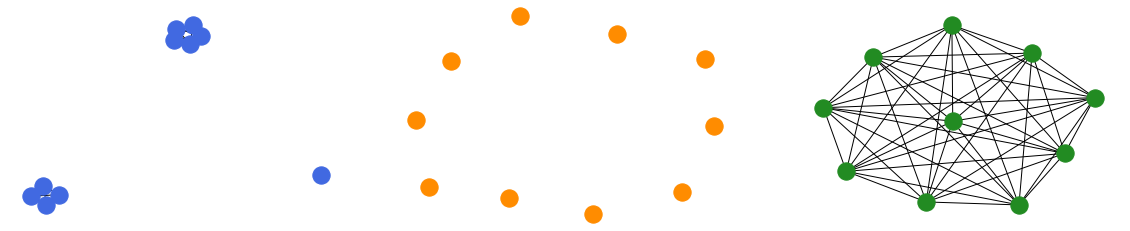

In [21]:
# Check that we can modify just a single graph's edges from a batch and
# only that graph changes
data = next(iter(data_loader))

graphs_0 = split_pyg_data_to_nx_graphs(data)
edges, edge_batch_inds = pyg_data_to_edge_vector(data, return_batch_inds=True)
edge_batch_inds = edge_batch_inds.cpu().numpy()

# Remove all edges from one graph
test_i = np.random.choice(edge_batch_inds)
mask = edge_batch_inds == test_i
edges[mask] = 0
data.edge_index = edge_vector_to_pyg_data(data, edges)
graphs_1 = split_pyg_data_to_nx_graphs(data)

# Add all edges to one graph
edges[mask] = 1
data.edge_index = edge_vector_to_pyg_data(data, edges)
graphs_2 = split_pyg_data_to_nx_graphs(data)

fig, ax = plt.subplots(ncols=3, figsize=(20, 4))
nx.draw(graphs_0[test_i], ax=ax[0], node_color="royalblue")
nx.draw(graphs_1[test_i], ax=ax[1], node_color="darkorange")
nx.draw(graphs_2[test_i], ax=ax[2], node_color="forestgreen")
plt.show()

for i in range(len(data.ptr) - 1):
    if test_i != i:
        assert nx.algorithms.isomorphism.is_isomorphic(graphs_0[i], graphs_1[i])
        assert nx.algorithms.isomorphism.is_isomorphic(graphs_0[i], graphs_2[i])
    else:
        assert not nx.algorithms.isomorphism.is_isomorphic(graphs_0[i], graphs_1[i])
        assert not nx.algorithms.isomorphism.is_isomorphic(graphs_0[i], graphs_2[i])

In [22]:
# Check that if we modify one graph in a batch (e.g. by changing edges or node features),
# only that graph's edge probabilities changes (as predicted from the model)
data = next(iter(data_loader))
model.eval()  # Disable normalization layers at test time

e0, edge_batch_inds = pyg_data_to_edge_vector(data, return_batch_inds=True)

# Fix some random time vector for the nodes
graph_times = torch.randint(t_limit, size=(data_loader.batch_size,), device=DEVICE) + 1
t_v = graph_times[data.batch].float()

# Run a forward pass through the model
preds_orig = model(data, t_v).detach().cpu().numpy()

# Pick a graph index to modify
test_i = np.random.choice(data_loader.batch_size)
edge_mask = edge_batch_inds == test_i
node_mask = data.batch == test_i

# Modify the edges for one graph and run another forward pass
e1 = torch.clone(e0)
e1[edge_mask] = 1 - e1[edge_mask]
data.edge_index = edge_vector_to_pyg_data(data, e1)
preds_edge_mod = model(data, t_v).detach().cpu().numpy()
data.edge_index = edge_vector_to_pyg_data(data, e0)  # Revert back
preds_edge_revert = model(data, t_v).detach().cpu().numpy()

# Modify the node features for the same graph and run another forward pass
node_feats0 = data.x
node_feats1 = torch.clone(node_feats0)
node_feats1[node_mask] = node_feats1[node_mask] + torch.randn_like(node_feats1[node_mask])
data.x = node_feats1
preds_node_mod = model(data, t_v).detach().cpu().numpy()
data.x = node_feats0  # Revert back
preds_node_revert = model(data, t_v).detach().cpu().numpy()

# Modify the time for the same graph and run another forward pass
t_v1 = torch.clone(t_v)
t_v1[node_mask] = t_v1[node_mask] + 1  # Might run over t_limit but it doesn't matter for the test
preds_t_mod = model(data, t_v1).detach().cpu().numpy()

edge_mask = edge_mask.cpu().numpy()  # For convenience

# Verify only that one graph's edge probabilities have changed from the model
assert np.allclose(preds_orig, preds_edge_revert)
assert np.allclose(preds_orig, preds_node_revert)
assert not np.allclose(preds_orig[edge_mask], preds_edge_mod[edge_mask])
assert not np.allclose(preds_orig[edge_mask], preds_node_mod[edge_mask])
assert not np.allclose(preds_orig[edge_mask], preds_t_mod[edge_mask])
assert np.allclose(preds_orig[~edge_mask], preds_edge_mod[~edge_mask])
assert np.allclose(preds_orig[~edge_mask], preds_node_mod[~edge_mask])
assert np.allclose(preds_orig[~edge_mask], preds_t_mod[~edge_mask])

Expected cycles in limit: 13.44
Expected edges in limit: 22.42


  0%|          | 0/999 [00:00<?, ?it/s]

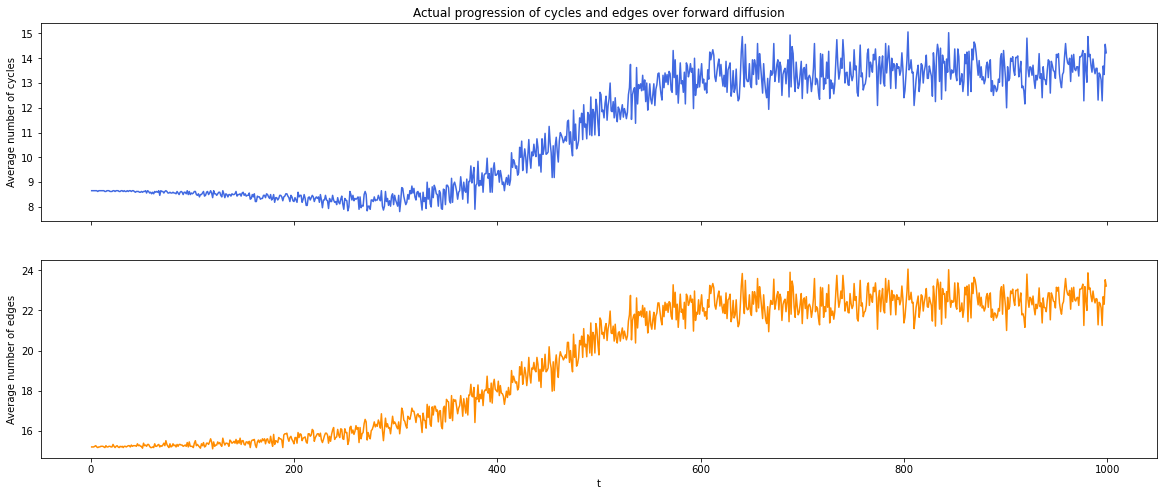

In [23]:
# Check progression of the number of cycles and edges
er_num_cycles, er_num_edges = [], []
for _ in range(500):
    er_graph = nx.erdos_renyi_graph(int(np.mean(num_nodes)), 0.5)
    er_num_cycles.append(len(nx.cycle_basis(er_graph)))
    er_num_edges.append(nx.number_of_edges(er_graph))

print("Expected cycles in limit: %.2f" % np.mean(er_num_cycles))
print("Expected edges in limit: %.2f" % np.mean(er_num_edges))

t_vals = np.arange(1, t_limit)
num_cycles = np.empty((len(t_vals), data_loader.batch_size))
num_edges = np.empty((len(t_vals), data_loader.batch_size))
data = next(iter(data_loader))
e0 = pyg_data_to_edge_vector(data)
for i, t in tqdm.notebook.tqdm(enumerate(t_vals), total=len(t_vals)):
    t_tens = torch.tensor([t], device=DEVICE)
    et = noise_input(e0[None], t_tens)[0]  # Do the noising on 1 x E tensors
    data.edge_index = edge_vector_to_pyg_data(data, et)  # Note: this modifies `data`
    
    # Convert to a list of NetworkX graphs
    graphs = split_pyg_data_to_nx_graphs(data)
    for j, g in enumerate(graphs):
        num_cycles[i, j] = len(nx.cycle_basis(g))
        num_edges[i, j] = nx.number_of_edges(g)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 8))
ax[0].plot(t_vals, np.mean(num_cycles, axis=1), color="royalblue")
ax[0].set_ylabel("Average number of cycles")

ax[1].plot(t_vals, np.mean(num_edges, axis=1), color="darkorange")
ax[1].set_ylabel("Average number of edges")
ax[1].set_xlabel("t")

ax[0].set_title("Actual progression of cycles and edges over forward diffusion")
plt.show()

  0%|          | 0/999 [00:00<?, ?it/s]

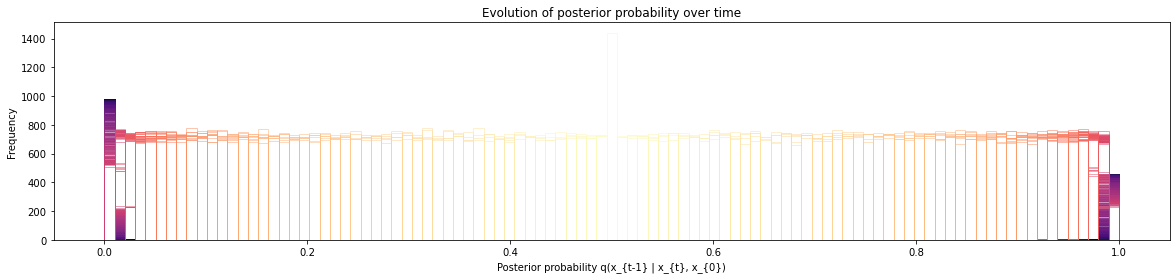

In [24]:
# Check progression of posterior probability
t_vals = np.arange(1, t_limit)
data = next(iter(data_loader))
e0 = pyg_data_to_edge_vector(data)
posterior_probs = np.empty((len(t_vals), e0.shape[0]))
for i, t in tqdm.notebook.tqdm(enumerate(t_vals), total=len(t_vals)):
    t_tens = torch.tensor([t], device=DEVICE)
    et = noise_input(e0[None], t_tens)[0]  # Do the noising on 1 x E tensors
    posterior_probs[i] = posterior_prob(e0, et, t_tens).cpu().numpy()
    
fig, ax = plt.subplots(figsize=(20, 4))
times = np.tile(t_vals[:, None], (1, posterior_probs.shape[1]))
cmap = plt.get_cmap("magma")
bins = np.linspace(0, 1, 100)
for t_i in range(len(t_vals)):
    ax.hist(posterior_probs[t_i], bins=bins, histtype="step", color=cmap(t_i / len(t_vals)), alpha=0.5)
ax.set_xlabel("Posterior probability q(x_{t-1} | x_{t}, x_{0})")
ax.set_ylabel("Frequency")
ax.set_title("Evolution of posterior probability over time")
plt.show()

### Train the model

In [25]:
# Train the model
model.train()
train_model(
    model, data_loader,
    t_limit=t_limit,
    num_epochs=30,
    learning_rate=0.01
)

Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 average loss: 0.65541


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2 average loss: 0.52033


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3 average loss: 0.45738


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4 average loss: 0.44881


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5 average loss: 0.43716


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6 average loss: 0.43395


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7 average loss: 0.43124


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8 average loss: 0.42225


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9 average loss: 0.41955


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10 average loss: 0.41581


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 11 average loss: 0.41790


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 12 average loss: 0.41120


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 13 average loss: 0.40665


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 14 average loss: 0.40798


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 15 average loss: 0.40686


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 16 average loss: 0.40071


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 17 average loss: 0.40033


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 18 average loss: 0.39600


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 19 average loss: 0.40364


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 20 average loss: 0.40268


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 21 average loss: 0.39436


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 22 average loss: 0.39186


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 23 average loss: 0.39598


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 24 average loss: 0.39648


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 25 average loss: 0.39452


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 26 average loss: 0.39617


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 27 average loss: 0.39436


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 28 average loss: 0.39312


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 29 average loss: 0.39021


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 30 average loss: 0.39188


### Sample generation

In [26]:
# Take the trained model and go backwards to sample some graphs
print("Sampling some reverse trajectories")

model.eval()  # Disable normalization layers

graphs = []  # List of NetworkX graphs generated through time
edge_probs = []  # List of posterior edge probabilities generated through time

# For simplicity, get a data batch and just run the forward
# diffusion process to sample
# TODO
data = next(iter(data_loader))
e0, edge_batch_inds = pyg_data_to_edge_vector(data, return_batch_inds=True)
edge_batch_inds = edge_batch_inds.cpu().numpy()
t_e = torch.tile(torch.tensor([t_limit], device=DEVICE), (e0.shape[0],))
et = noise_input(e0[:, None], t_e)[:, 0]  # Do the noising on E x 1 tensors
data.edge_index = edge_vector_to_pyg_data(data, et)
graphs.append(split_pyg_data_to_nx_graphs(data))

for t in tqdm.notebook.trange(t_limit - 1, 0, -1):
    t_v = torch.tile(
        torch.tensor([t], device=DEVICE), (data.x.shape[0],)
    )
    p = model(data, t_v)
    edge_probs.append(p.detach().cpu().numpy())
    edges = torch.bernoulli(p)
    data.edge_index = edge_vector_to_pyg_data(data, edges)
    graphs.append(split_pyg_data_to_nx_graphs(data))

Sampling some reverse trajectories


  0%|          | 0/999 [00:00<?, ?it/s]

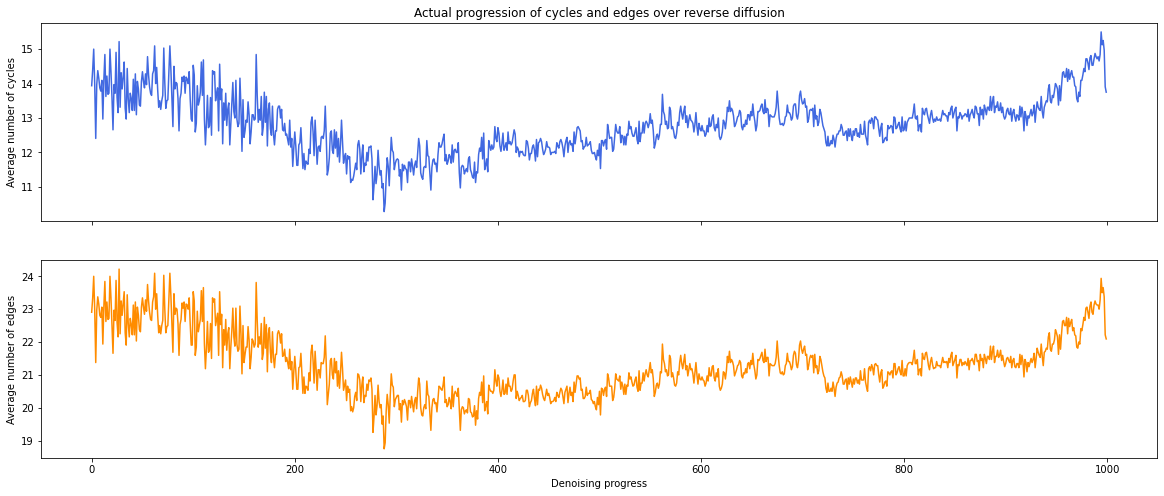

In [27]:
# Check progression of the number of cycles and edges
num_cycles = np.empty((len(graphs), len(graphs[0])))
num_edges = np.empty((len(graphs), len(graphs[0])))
for i in range(len(graphs)):
    for j, g in enumerate(graphs[i]):
        num_cycles[i, j] = len(nx.cycle_basis(g))
        num_edges[i, j] = nx.number_of_edges(g)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 8))
ax[0].plot(np.arange(len(graphs)), np.mean(num_cycles, axis=1), color="royalblue")
ax[0].set_ylabel("Average number of cycles")

ax[1].plot(np.arange(len(graphs)), np.mean(num_edges, axis=1), color="darkorange")
ax[1].set_ylabel("Average number of edges")
ax[1].set_xlabel("Denoising progress")

ax[0].set_title("Actual progression of cycles and edges over reverse diffusion")
plt.show()

0


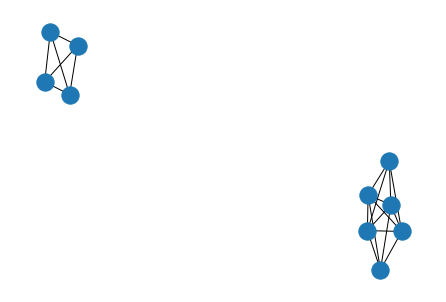

1


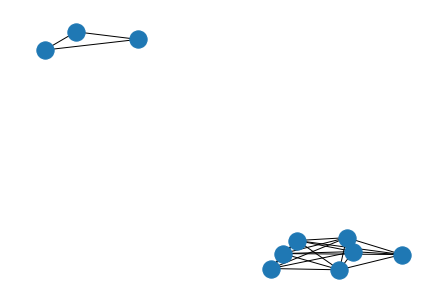

2


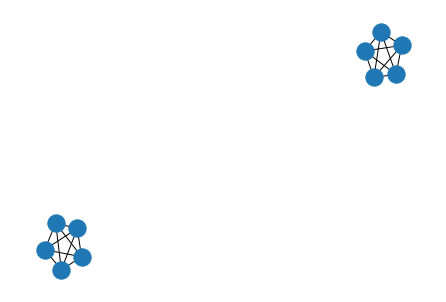

3


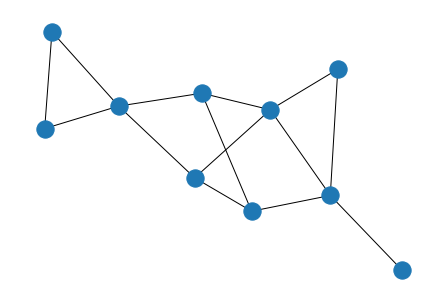

4


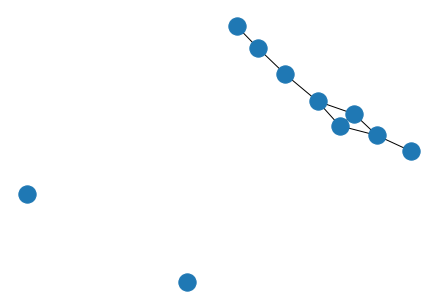

5


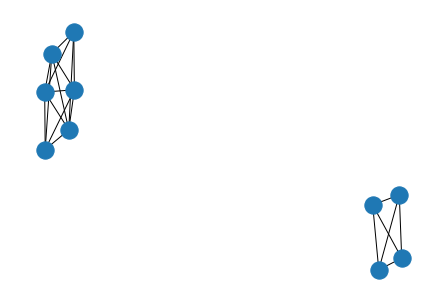

6


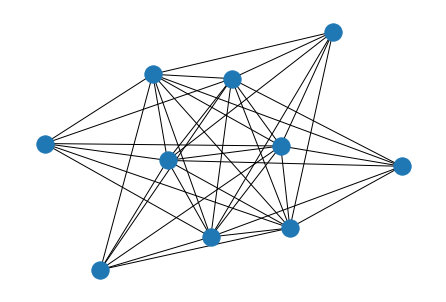

7


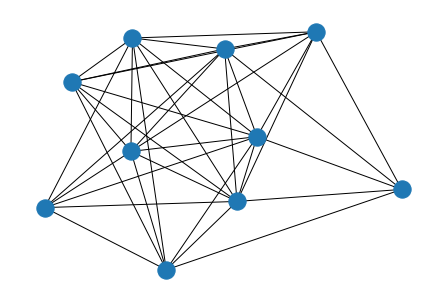

8


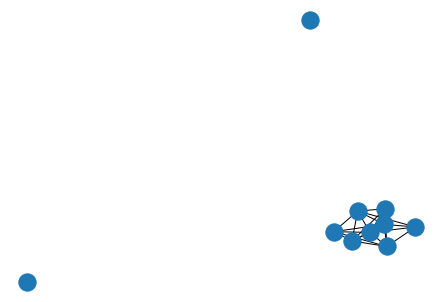

9


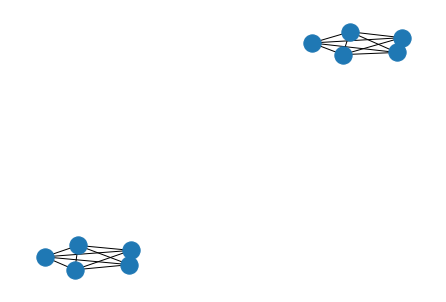

10


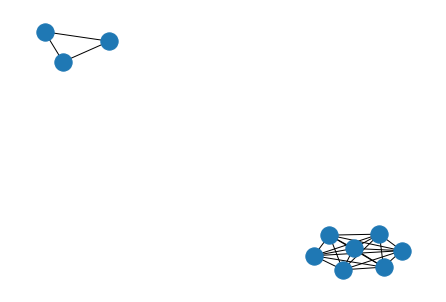

11


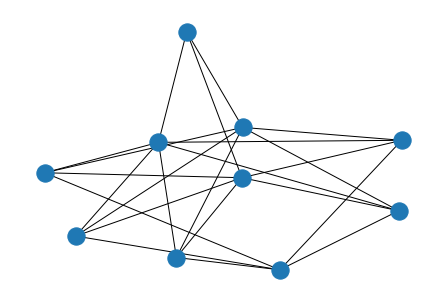

12


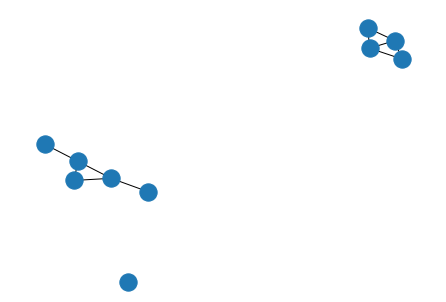

13


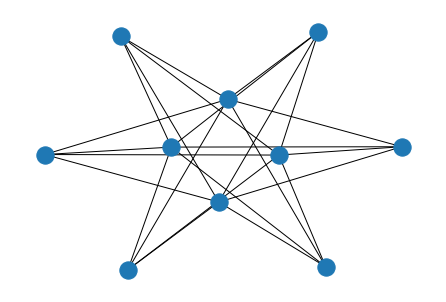

14


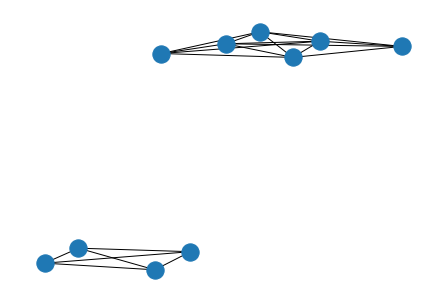

15


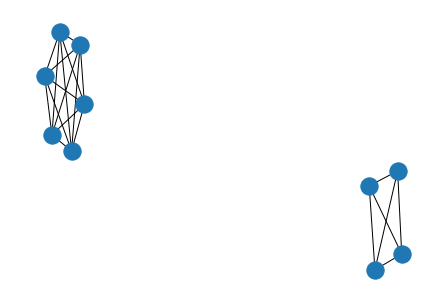

16


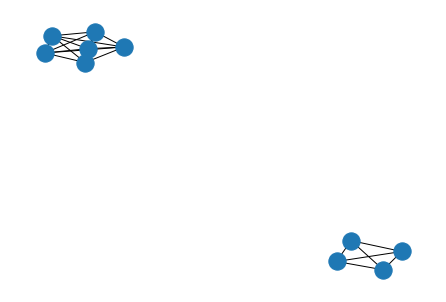

17


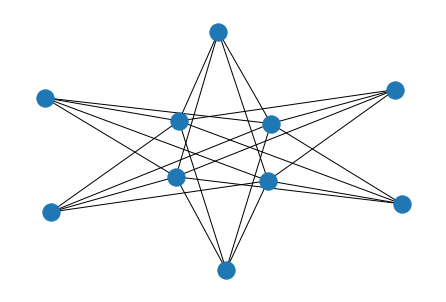

18


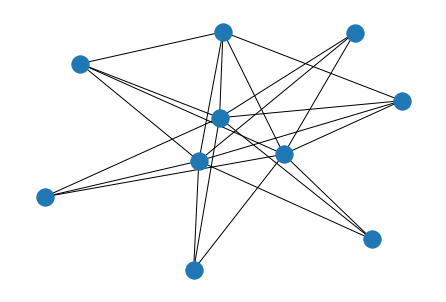

19


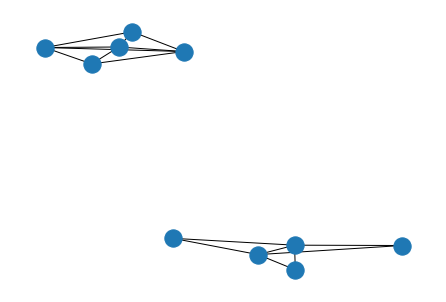

20


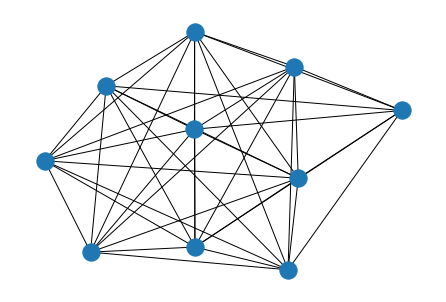

21


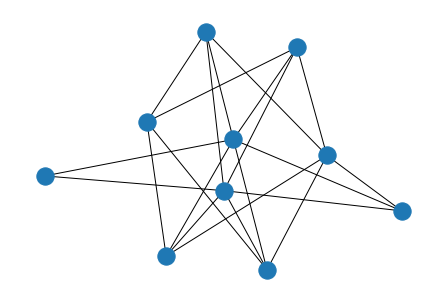

22


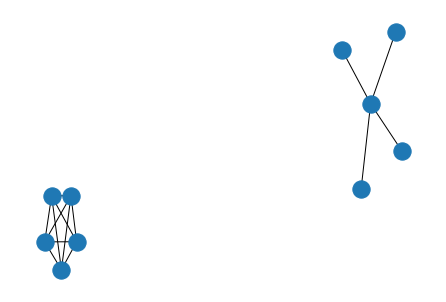

23


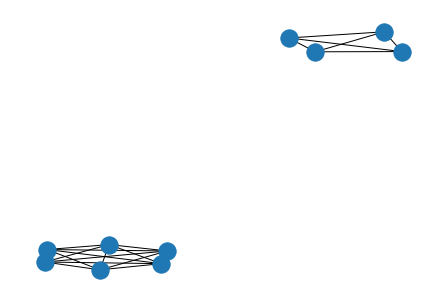

24


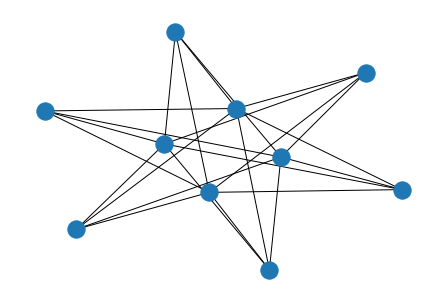

25


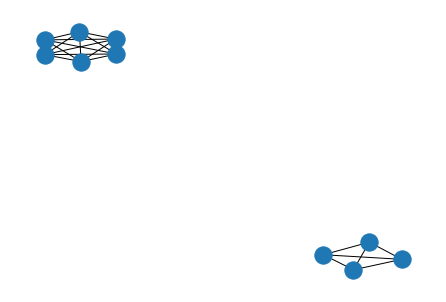

26


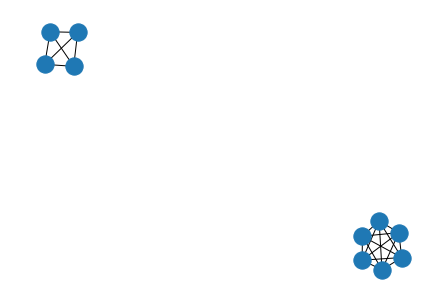

27


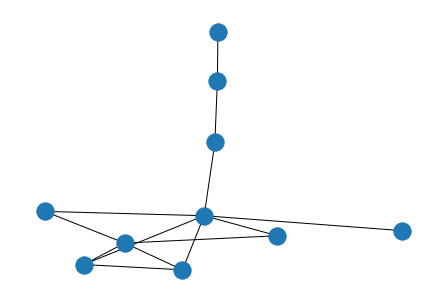

28


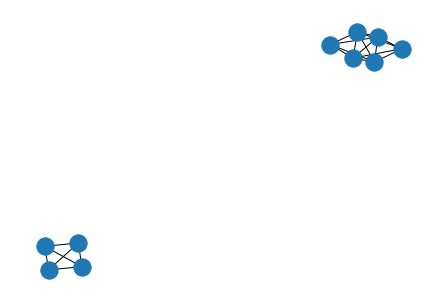

29


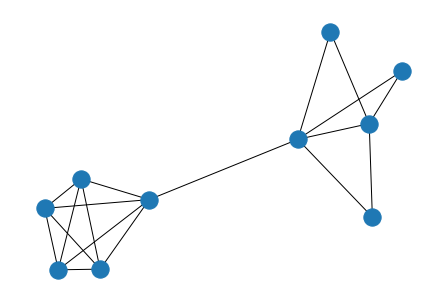

30


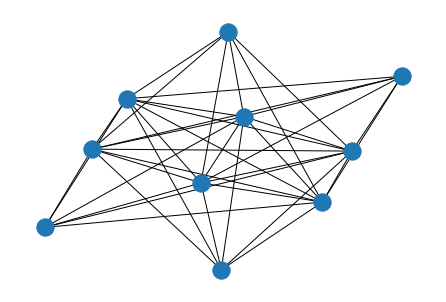

31


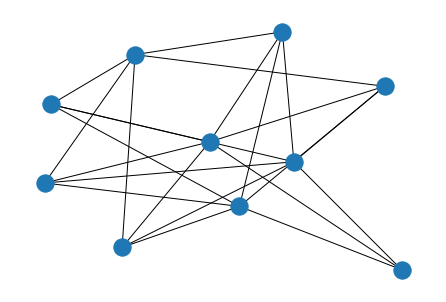

In [28]:
# Plot some randomly generated graphs
for i in range(len(graphs[-1])):
    print(i)
    nx.draw(graphs[-1][i])
    plt.show()

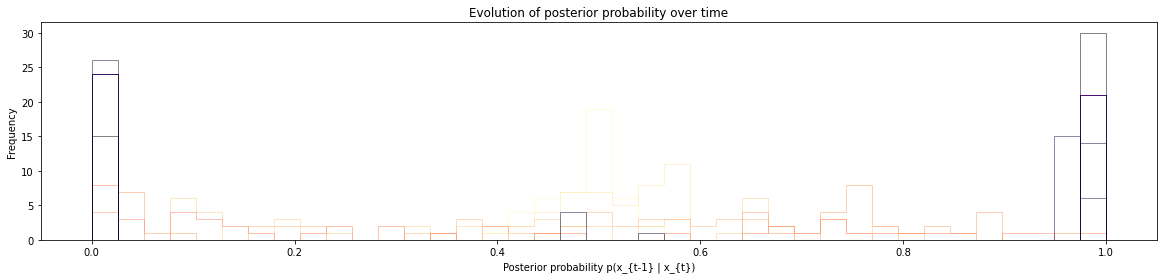

0


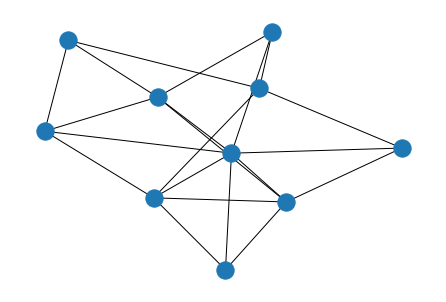

50


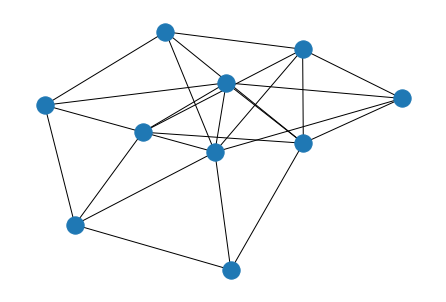

100


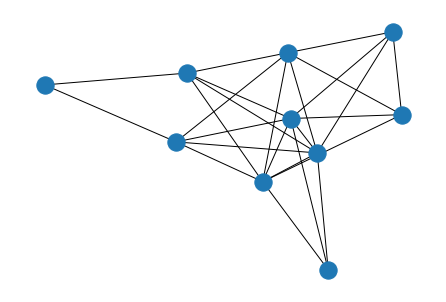

150


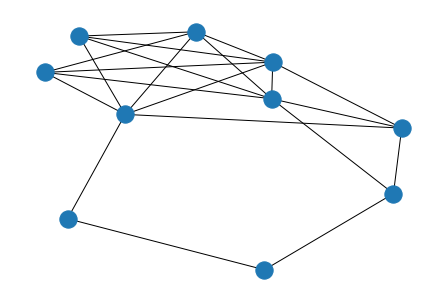

200


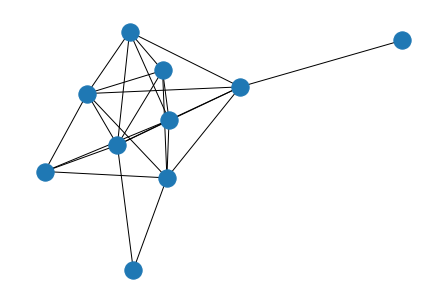

250


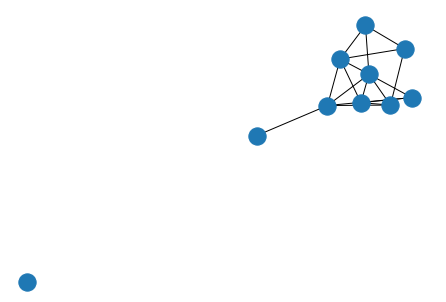

300


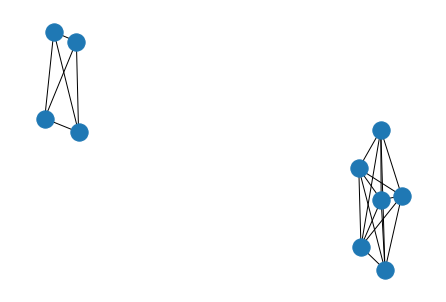

350


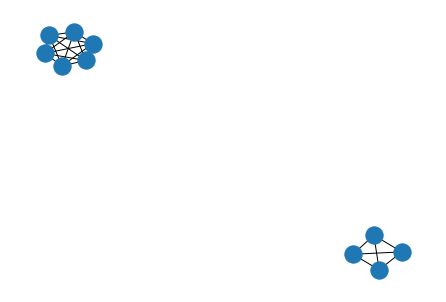

400


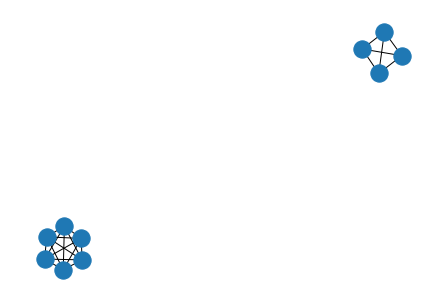

450


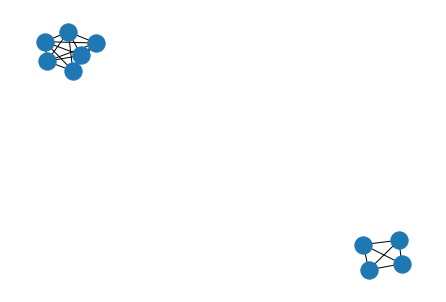

500


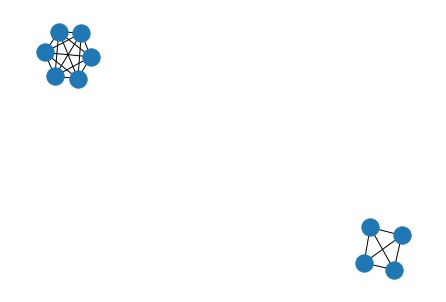

550


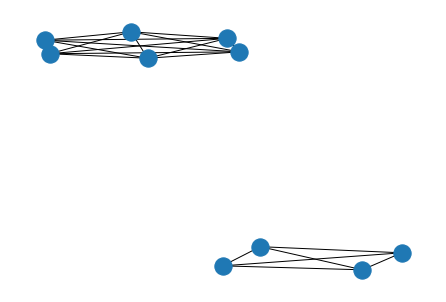

600


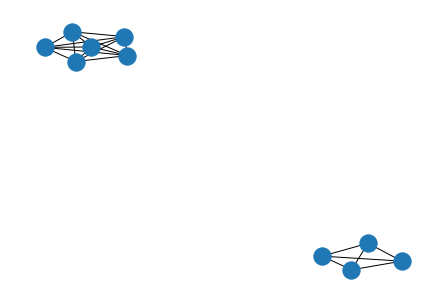

650


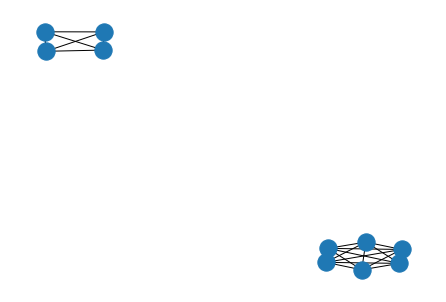

700


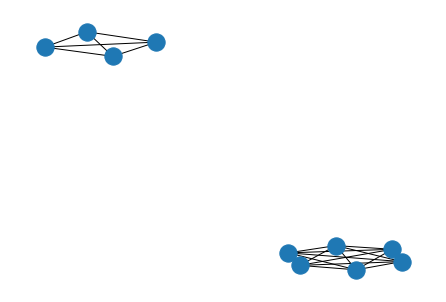

750


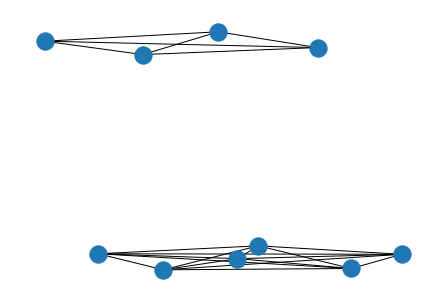

800


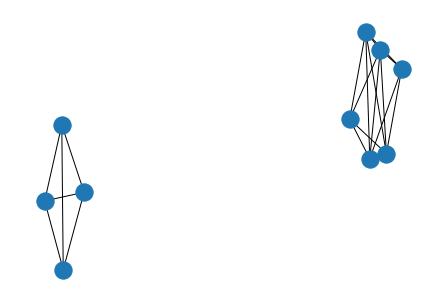

850


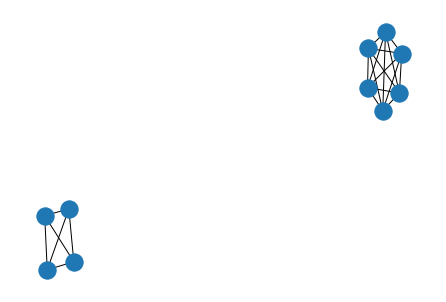

900


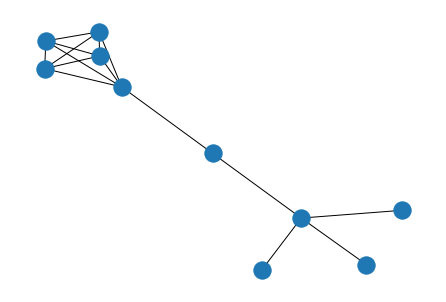

950


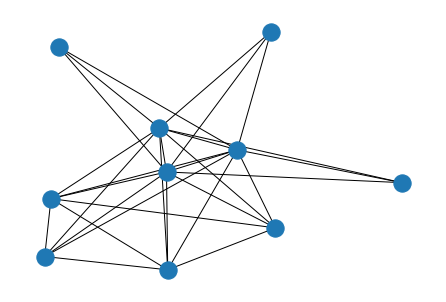

In [29]:
i = 30

mask = edge_batch_inds == i
probs = [p[mask] for p in edge_probs]

fig, ax = plt.subplots(figsize=(20, 4))
cmap = plt.get_cmap("magma")
bins = np.linspace(0, 1, 40)
for t_i in np.arange(0, len(probs), 50):
    ax.hist(probs[t_i], bins=bins, histtype="step", color=cmap(1 - (t_i / len(probs))), alpha=0.5)
ax.set_xlabel("Posterior probability p(x_{t-1} | x_{t})")
ax.set_ylabel("Frequency")
ax.set_title("Evolution of posterior probability over time")
plt.show()

for t in np.arange(0, len(graphs), 50):
    print(t)
    nx.draw(graphs[t][i])
    plt.show()